In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/27-class-sign-language-dataset/Y.npy
/kaggle/input/27-class-sign-language-dataset/X.npy


In [47]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from keras.models import Model
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D,Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [3]:
# Load features (images) and labels
X = np.load('/kaggle/input/27-class-sign-language-dataset/X.npy')
y = np.load('/kaggle/input/27-class-sign-language-dataset/Y.npy')

In [4]:
def resize_images(images, target_size=(128,128)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size)
        resized_images.append(resized)
    return np.array(resized_images)

X_resized = resize_images(X)

In [5]:
images = X.astype('float32')
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y.reshape(-1))
y_categorical = to_categorical(labels)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,  
    fill_mode='nearest'
)
X_train, X_val, y_train, y_val = train_test_split(
    X_resized, y_categorical, test_size=0.2, random_state=42
)

train_generator = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=32,
    shuffle=True
)

try2 


In [7]:
!pip install git+https://github.com/ml-jku/hopfield-layers

  Cloning https://github.com/ml-jku/hopfield-layers to /tmp/pip-req-build-1xpm_45d
  Running command git clone --filter=blob:none --quiet https://github.com/ml-jku/hopfield-layers /tmp/pip-req-build-1xpm_45d
  Resolved https://github.com/ml-jku/hopfield-layers to commit f56f929c95b77a070ae675ea4f56b6d54d36e730
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 10.8 MB/s eta 0:00:00:00:0100:01
  Creat

In [8]:
import torch
import torch.nn as nn
from hflayers import Hopfield
from torch.utils.data import TensorDataset, DataLoader

In [9]:
class HopfieldNet(nn.Module):
    def __init__(self, hidden_dim=512, num_classes=27):
        super(HopfieldNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),                             

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                             

            nn.Conv2d(64, 128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),                             

            nn.Flatten()                                  
        )

        self.projector = nn.Linear(128 * 16 * 16, hidden_dim)
        self.dropout = nn.Dropout(0.5)

        self.hopfield = Hopfield(input_size=hidden_dim, hidden_size=hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.encoder(x)                             
        x = self.projector(x)                           
        x = self.dropout(x)

        x = x.unsqueeze(1).repeat(1, 5, 1)              
        mask = torch.ones(x.size(0), x.size(1), dtype=torch.bool).to(x.device)

        x = self.hopfield(x, stored_pattern_padding_mask=~mask) )
        x = x.mean(dim=1)                                

        return self.classifier(x)


In [10]:
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2)
X_val = torch.from_numpy(X_val).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train).argmax(dim=1)
y_val = torch.from_numpy(y_val).argmax(dim=1)





train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HopfieldNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(20):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")


Epoch 1, Loss: 938.3956, Accuracy: 0.4949
Epoch 2, Loss: 414.4776, Accuracy: 0.7617
Epoch 3, Loss: 256.7819, Accuracy: 0.8520
Epoch 4, Loss: 192.3283, Accuracy: 0.8916
Epoch 5, Loss: 140.7788, Accuracy: 0.9209
Epoch 6, Loss: 110.2817, Accuracy: 0.9400
Epoch 7, Loss: 102.0219, Accuracy: 0.9461
Epoch 8, Loss: 86.6839, Accuracy: 0.9513
Epoch 9, Loss: 82.4765, Accuracy: 0.9578
Epoch 10, Loss: 102.6731, Accuracy: 0.9480
Epoch 11, Loss: 64.8468, Accuracy: 0.9664
Epoch 12, Loss: 69.1369, Accuracy: 0.9654
Epoch 13, Loss: 63.7361, Accuracy: 0.9703
Epoch 14, Loss: 65.4263, Accuracy: 0.9706
Epoch 15, Loss: 65.1066, Accuracy: 0.9687
Epoch 16, Loss: 61.4644, Accuracy: 0.9702
Epoch 17, Loss: 47.7774, Accuracy: 0.9783
Epoch 18, Loss: 59.6520, Accuracy: 0.9741
Epoch 19, Loss: 47.7291, Accuracy: 0.9778
Epoch 20, Loss: 45.8813, Accuracy: 0.9800


In [12]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy


In [13]:
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Validation Accuracy: 87.28%
Validation Loss: 1.3326


In [14]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=60a34618c13370e4624c3658e17407f11bcc26604330cb89f21e4aebf390fd80
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch
import matplotlib.pyplot as plt
import gc 


/tmp/ipykernel_31/1871178810.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


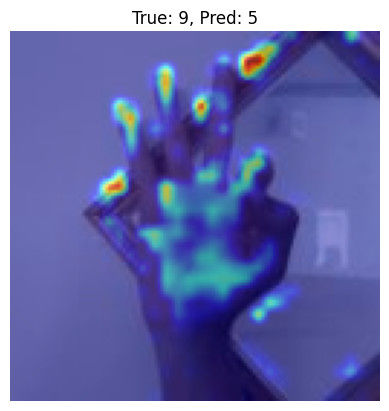

In [16]:
i = 0 
input_tensor = X_val[i].unsqueeze(0).to(device)
true_label = y_val[i].item()

with torch.no_grad():
    pred = torch.argmax(model(input_tensor), dim=1).item()

target_layer = model.encoder[-4]
cam = GradCAM(model=model, target_layers=[target_layer])

targets = [ClassifierOutputTarget(pred)]

with torch.cuda.amp.autocast(enabled=False):
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

rgb_img = X_val[i].permute(1, 2, 0).numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.title(f"True: {true_label}, Pred: {pred}")
plt.axis('off')
plt.show()

del input_tensor, grayscale_cam, cam
gc.collect()
torch.cuda.empty_cache()


  0%|          | 0/100 [00:00<?, ?it/s]

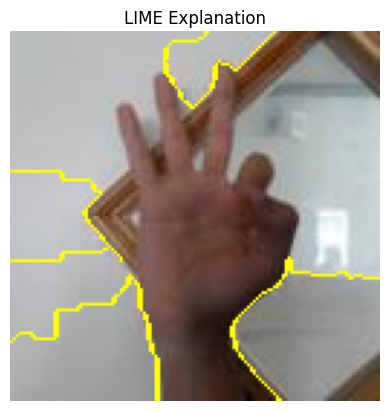

In [17]:
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries

def predict_fn(images):
    model.eval()
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)  
    with torch.no_grad():
        logits = model(images)
        probs = F.softmax(logits, dim=1)
    return probs.cpu().numpy()


img_tensor = X_val[i]
img = img_tensor.permute(1, 2, 0).cpu().numpy()  


explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image=img.astype('double'),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=100
)

# Visualize
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()


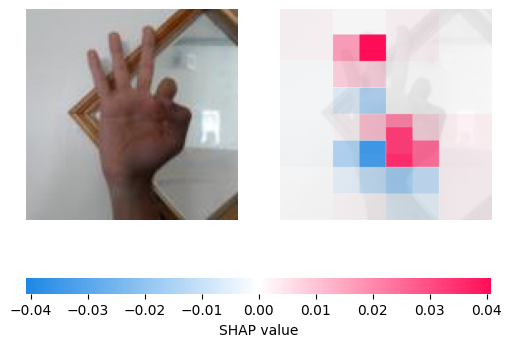

In [48]:
import shap
from shap.maskers import Image

model.eval()

device = next(model.parameters()).device

i = 0  
test_images = X_val[i:i+1]  

if isinstance(test_images, torch.Tensor):
    test_images = test_images.detach().cpu().numpy()

if test_images.shape[1] in [1, 3]: 
    test_images = np.transpose(test_images, (0, 2, 3, 1))

test_tensor = torch.tensor(np.transpose(test_images, (0, 3, 1, 2)), dtype=torch.float32).to(device)

with torch.no_grad():
    logits = model(test_tensor)
    pred_class = torch.argmax(logits[0]).item()

def predict_numpy(x):
    x_tensor = torch.tensor(np.transpose(x, (0, 3, 1, 2)), dtype=torch.float32).to(device)
    with torch.no_grad():
        out = model(x_tensor)
        return out[:, pred_class].detach().cpu().numpy()


masker = Image("blur(128,128)", test_images[0].shape)

explainer = shap.Explainer(predict_numpy, masker)
shap_values = explainer(test_images)
shap.plots.image(shap_values)



Processing sample 0
Predicted class: 5, Baseline probability: 0.9087


Ablating rows: 100%|██████████| 15/15 [00:00<00:00, 28.36it/s]


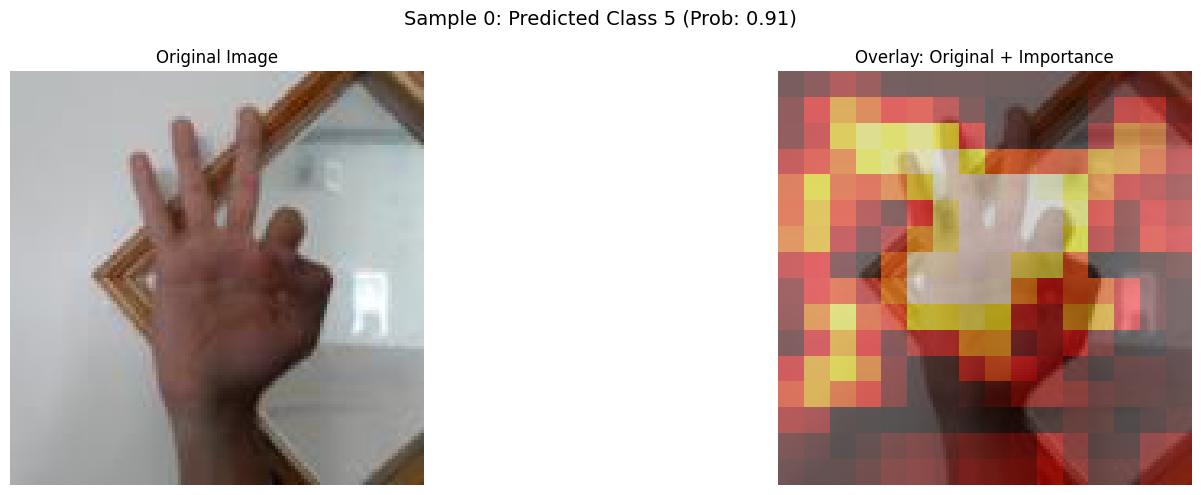


Processing sample 1
Predicted class: 24, Baseline probability: 1.0000


Ablating rows: 100%|██████████| 15/15 [00:00<00:00, 28.61it/s]


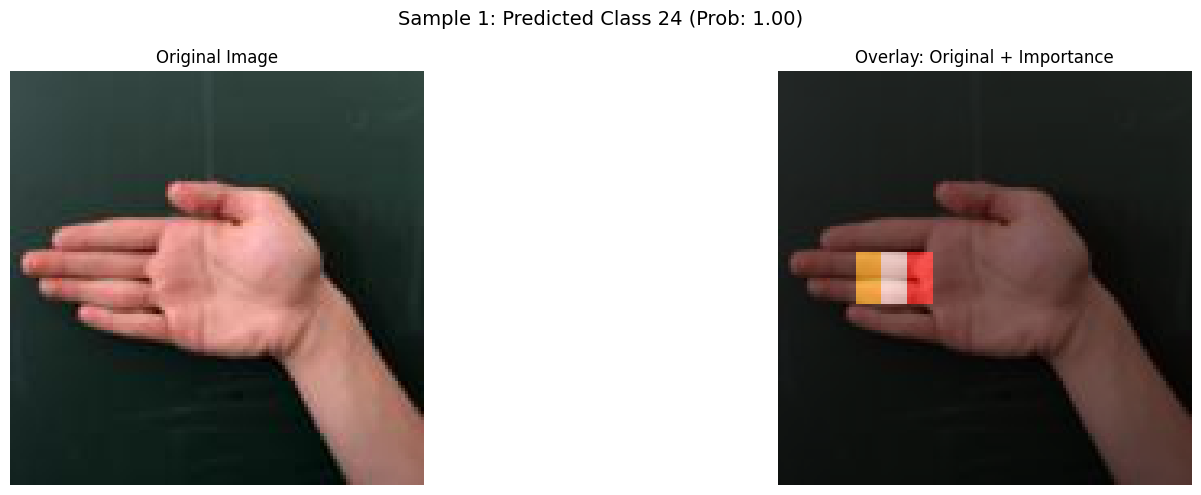


Processing sample 2
Predicted class: 12, Baseline probability: 0.9998


Ablating rows: 100%|██████████| 15/15 [00:00<00:00, 28.35it/s]


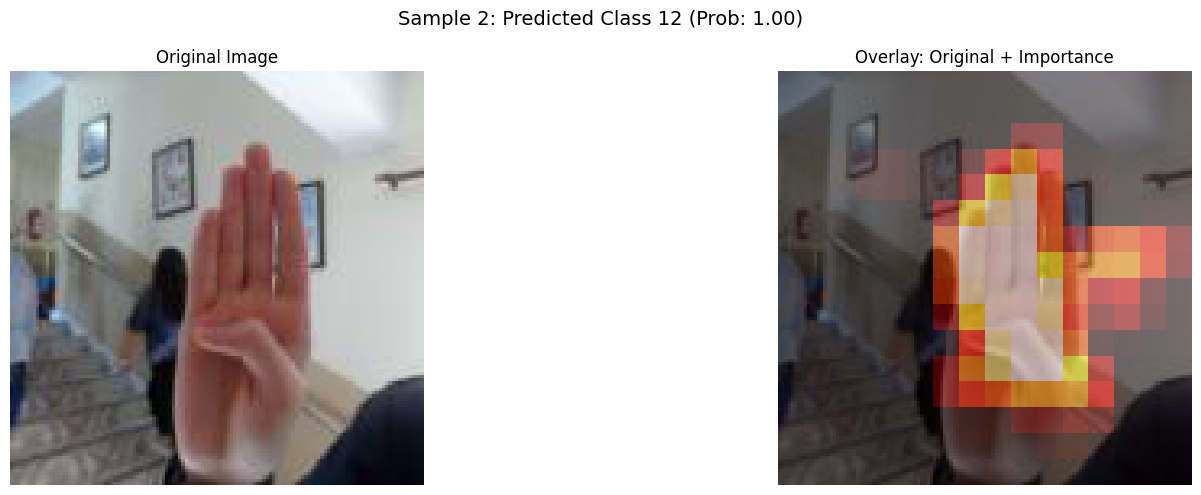


Processing sample 3
Predicted class: 21, Baseline probability: 0.9995


Ablating rows: 100%|██████████| 15/15 [00:00<00:00, 27.69it/s]


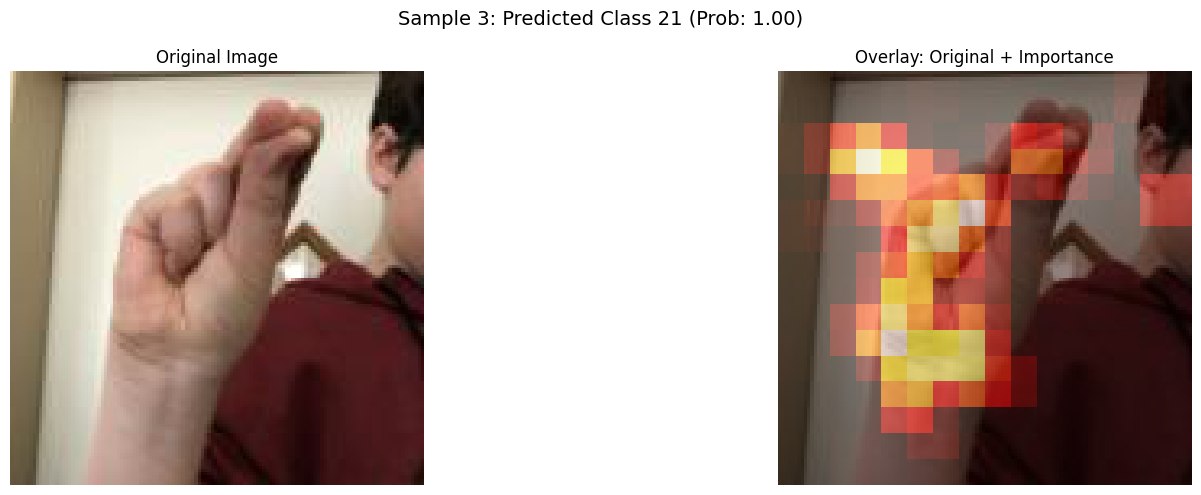


Processing sample 4
Predicted class: 17, Baseline probability: 1.0000


Ablating rows: 100%|██████████| 15/15 [00:00<00:00, 28.22it/s]


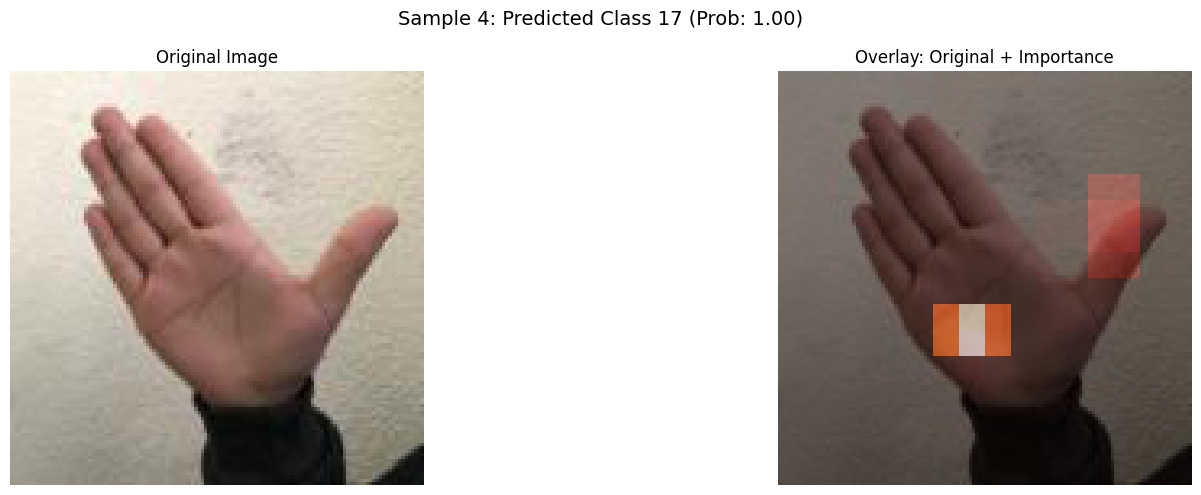

In [46]:
model.eval()

device = next(model.parameters()).device


num_samples = 5  
patch_size = 16
stride = 8
ablation_value = 0.0  

for i in range(num_samples):
    print(f"\nProcessing sample {i}")

    test_image = X_val[i:i+1]  # Shape (1, C, H, W)
    if isinstance(test_image, torch.Tensor):
        test_image = test_image.detach().cpu().numpy()

    c = test_image.shape[1]
    test_image_vis = np.transpose(test_image, (0, 2, 3, 1)).astype(np.float32)
    if test_image_vis.max() > 1.0:
        test_image_vis /= 255.0

    test_tensor = torch.tensor(np.transpose(test_image_vis, (0, 3, 1, 2)), dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(test_tensor)
        pred_class = torch.argmax(logits[0]).item()
        baseline_prob = torch.softmax(logits, dim=1)[0, pred_class].item()

    print(f"Predicted class: {pred_class}, Baseline probability: {baseline_prob:.4f}")
    _, h, w, _ = test_image_vis.shape
    importance_map = np.zeros((h, w))
    normalization_mask = np.zeros((h, w))
    image_tensor = torch.tensor(np.transpose(test_image_vis, (0, 3, 1, 2)), dtype=torch.float32).to(device)

    for y in tqdm(range(0, h - patch_size + 1, stride), desc="Ablating rows"):
        for x in range(0, w - patch_size + 1, stride):
            ablated_image = image_tensor.clone()
            ablated_image[:, :, y:y+patch_size, x:x+patch_size] = ablation_value

            with torch.no_grad():
                logits = model(ablated_image)
                ablated_prob = torch.softmax(logits, dim=1)[0, pred_class].item()

            importance = baseline_prob - ablated_prob
            importance_map[y:y+patch_size, x:x+patch_size] += importance
            normalization_mask[y:y+patch_size, x:x+patch_size] += 1


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(test_image_vis[0], cmap='gray' if c == 1 else None)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(test_image_vis[0], cmap='gray' if c == 1 else None)
    plt.imshow(importance_map, cmap='hot', alpha=0.5)
    plt.title("Overlay: Original + Importance")
    plt.axis('off')

    plt.suptitle(f"Sample {i}: Predicted Class {pred_class} (Prob: {baseline_prob:.2f})", fontsize=14)
    plt.tight_layout()
    plt.show()
